## Setup

In [1]:
# Libraries
import pandas as pd
import numpy as np
import gpflow 
import pickle
from helper_functions import *

# Options
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Data
# Read in metabolomics data
mbx = pd.read_csv('../examples/iHMP/data/iHMP_labeled_metabolomics.csv')
# Subset metabolites to labeled sets

# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)
# Only keep metabolites that have at least 20% non-missing values
mbx_list = mbx_list[(mbx.notna().mean() >= 0.2).values]
mbx = mbx[mbx_list]

# Read in metadata for timing of samples
meta = pd.read_csv('../examples/iHMP/data/iHMP_metadata.csv')
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi']]
meta.set_index('External ID', inplace = True)

# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(mbx, #log_mbx, 
                 left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Find the max HBI day for each ID
max_date = df[['id', 'hbi', 'date']].\
    dropna(subset=['hbi']).\
    sort_values('hbi').\
    groupby('id').\
    tail(1).\
    drop(columns=['hbi']).\
    rename(columns={'date': 'max_hbi_date'})

# Merge this back to df
df = pd.merge(df, max_date, on='id')
df['days_to_max_hbi'] = (df.max_hbi_date - df.date).dt.days
df = df.drop(columns=['max_hbi_date'])

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing HBI for the moment
df = df[df.hbi.notna()]

# Only keep metabolites 

# Standardize hbi and days for convergence properties
df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
df.days_to_max_hbi = (df.days_to_max_hbi - df.days_to_max_hbi.mean())/df.days_to_max_hbi.std()
df.hbi = (df.hbi - df.hbi.mean())/df.hbi.std()

# Store individual information look up vectors
n_id = df.id.nunique()
id_list = df.id.unique()
id_vals = df.id.values
id_idx = np.array([np.where(id_list == x)[0][0] for x in id_vals])
df['id'] = id_idx

# Normalize columns
# df.days_from_start = (df.days_from_start.max() - df.days_from_start)/(df.days_from_start.max()-df.days_from_start.min())
# df.hbi = (df.hbi.max() - df.hbi)/(df.hbi.max() - df.hbi.min())
# df.id = (df.id.max() - df.id)/(df.id.max() - df.id.min())
# df.id = (df.id - df.id.mean())/df.id.std()
print(df.shape)
df.head()

(241, 548)


/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id       hbi  12.13-diHOME  9.10-diHOME  caproate  heptanoate  \
0   0  0.628714      942546.0    1418451.0    2194.0         NaN   
1   0  0.241690      584730.0    1955625.0    2305.0         NaN   
2   0  0.241690      555437.0     739486.0     670.0         NaN   
3   0  0.628714      937676.0    1002635.0    1295.0         NaN   
4   0  1.789787     1286163.0    1453551.0    2920.0         NaN   

   hydrocinnamate  mandelate  2-hydroxyoctanoate  3-hydroxyoctanoate  ...  \
0         38180.0     5893.0                 NaN              4174.0  ...   
1         69475.0    10406.0                 NaN              6601.0  ...   
2          9780.0     6117.0                 NaN              5480.0  ...   
3         17147.0     9764.0                 NaN              6779.0  ...   
4         23123.0     6514.0                 NaN              3975.0  ...   

   C18:1 LPC plasmalogen  C18:0 LPE-A  C18:0 LPE-B   C22:6 LPE  \
0               453688.0    9997928.0    3579319.0   2066660.0   
1               130737.0   16335239.0   13177075.0   4447184.0   
2                 3760.0    4371214.0    2130907.0  10511485.0   
3                18460.0    3306645.0    2323331.0   1555152.0   
4                    NaN    8323839.0    2529248.0   4901090.0   

   sphingosine-isomer1  sphingosine-isomer2  sphingosine-isomer3  C14:0 SM  \
0          274385476.0          136360623.0          211906815.0   36328.0   
1          121055143.0           65245288.0          301546342.0   51577.0   
2          199161782.0          106462063.0          118183128.0       NaN   
3          187973992.0           97169686.0           72151914.0       NaN   
4          152639719.0           79560140.0          225812346.0    6212.0   

   days_from_start  days_to_max_hbi  
0        -1.821219         2.046982  
1        -1.539290         1.654917  
2        -1.227153         1.220845  
3        -0.814328         0.646750  
4        -0.456882         0.149668  

[5 rows x 548 columns]

## TODO
Is there a way that we can cut down the number of models built by only exploring the "promising" ones, i.e. through the use of ARD?

In [1]:
# X_ = df[['id', 'hbi', 'days_from_start']]
# X_.loc[:,b'id_hbi'] = X_['id']*X_['hbi']
# X_ = X_.to_numpy().reshape(-1, 4)#3)
# Y_ = df[[m]].to_numpy().reshape(-1, 1)

# x_idx = ~np.isnan(X_).any(axis=1)
# y_idx = ~np.isnan(Y_).flatten()

# X_ = X_[x_idx & y_idx]
# Y_ = Y_[x_idx & y_idx]

# base_kerns = [gpflow.kernels.Matern12(active_dims=[x]) for x in np.arange(1)]

# foo2 = gpflow.models.VGP(
#     data = (X_, Y_),
#     kernel = gpflow.kernels.Matern12(lengthscales=[1,1,1,1]),
# #     kernel = gpflow.kernels.Sum(base_kerns),#+\
#                                 #[gpflow.utilities.deepcopy(x)*gpflow.utilities.deepcopy(y) 
#                                 # for x,y in zip(base_kerns, base_kerns[1:])]),
#     likelihood=gpflow.likelihoods.Gamma())#gpflow.likelihoods.Gamma())

# optimizer = gpflow.optimizers.Scipy()
# optimizer.minimize(foo2.training_loss, foo2.trainable_variables)

# foo2

## iHMP Stage One Model Search

In [7]:
missing_df = df[mbx_list].isna().mean()
missing_mbx_list = mbx_list[(missing_df>=0.1).values].reset_index(drop=True)

In [8]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

# Number of metabolites
n_met = len(missing_mbx_list)

# np.random.seed(9102)
# Run this process for multiple metabolites independently
with tqdm_joblib(tqdm(desc="Kernel search", total=n_met)) as progress_bar:
    binomial_models = Parallel(n_jobs=-2, verbose=1)(delayed(full_kernel_search)(
            X=df[['id', 'hbi', 'days_from_start', 'days_to_max_hbi']].to_numpy().reshape(-1, 4),
            Y=df[[m]].notna().astype(int).to_numpy().reshape(-1, 1),
            kern_list=kernel_list,
            cat_vars=[0],
            max_depth=5,
            early_stopping=True,
            prune=True,
            keep_all=False,
            lik='bernoulli',
            keep_only_best=True,
            random_seed=9102)
        for m in missing_mbx_list[:n_met])

# # Run this process also for the intensity values themselves
# with tqdm_joblib(tqdm(desc="Kernel search", total=n_met)) as progress_bar:
#     gamma_models = Parallel(n_jobs=-2, verbose=1)(delayed(full_kernel_search)(
#             X=df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
#             Y=df[[m]].to_numpy().reshape(-1, 1),
#             kern_list=kernel_list,
#             cat_vars=[0],
#             max_depth=5,
#             early_stopping=True,
#             prune=True,
#             keep_all=False,
#             lik='gamma')
#         for m in mbx_list[:n_met])
    
# Transform list output into dictionary to pull of metabolites of interest
# binomial_dict = {k: v[0] for k,v in zip(missing_mbx_list[:n_met], binomial_models)}
# gamma_dict = {k: v[0] for k, v in zip(mbx_list[:n_met], gamma_models)}

Kernel search:  93%|████████████████████▍ | 104/112 [13:53:03<30:43, 230.42s/it]

Error!


Kernel search:  96%|█████████████████████ | 107/112 [14:39:51<49:38, 595.80s/it]

Error!


Kernel search:  96%|█████████████████████▏| 108/112 [15:03:16<55:54, 838.61s/it]

Error!


Kernel search:  97%|█████████████████████▍| 109/112 [15:10:12<35:34, 711.60s/it]

Error!
Error!


Kernel search: 100%|██████████████████████| 112/112 [17:48:20<00:00, 572.33s/it]


Error!


In [10]:
import pickle 
# Save output
f = open("ihmp_binomial_models.pkl","wb")
pickle.dump(binomial_models, f)
f.close()

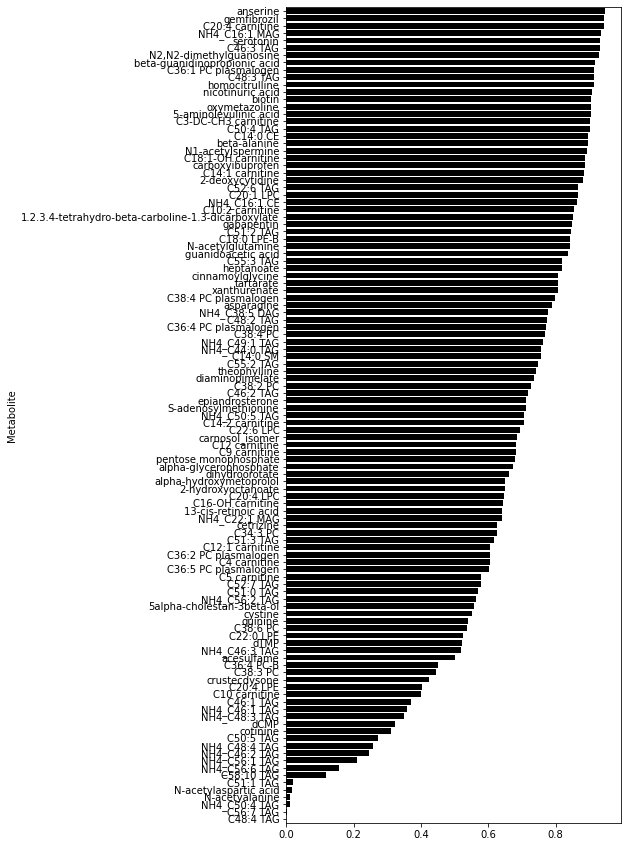

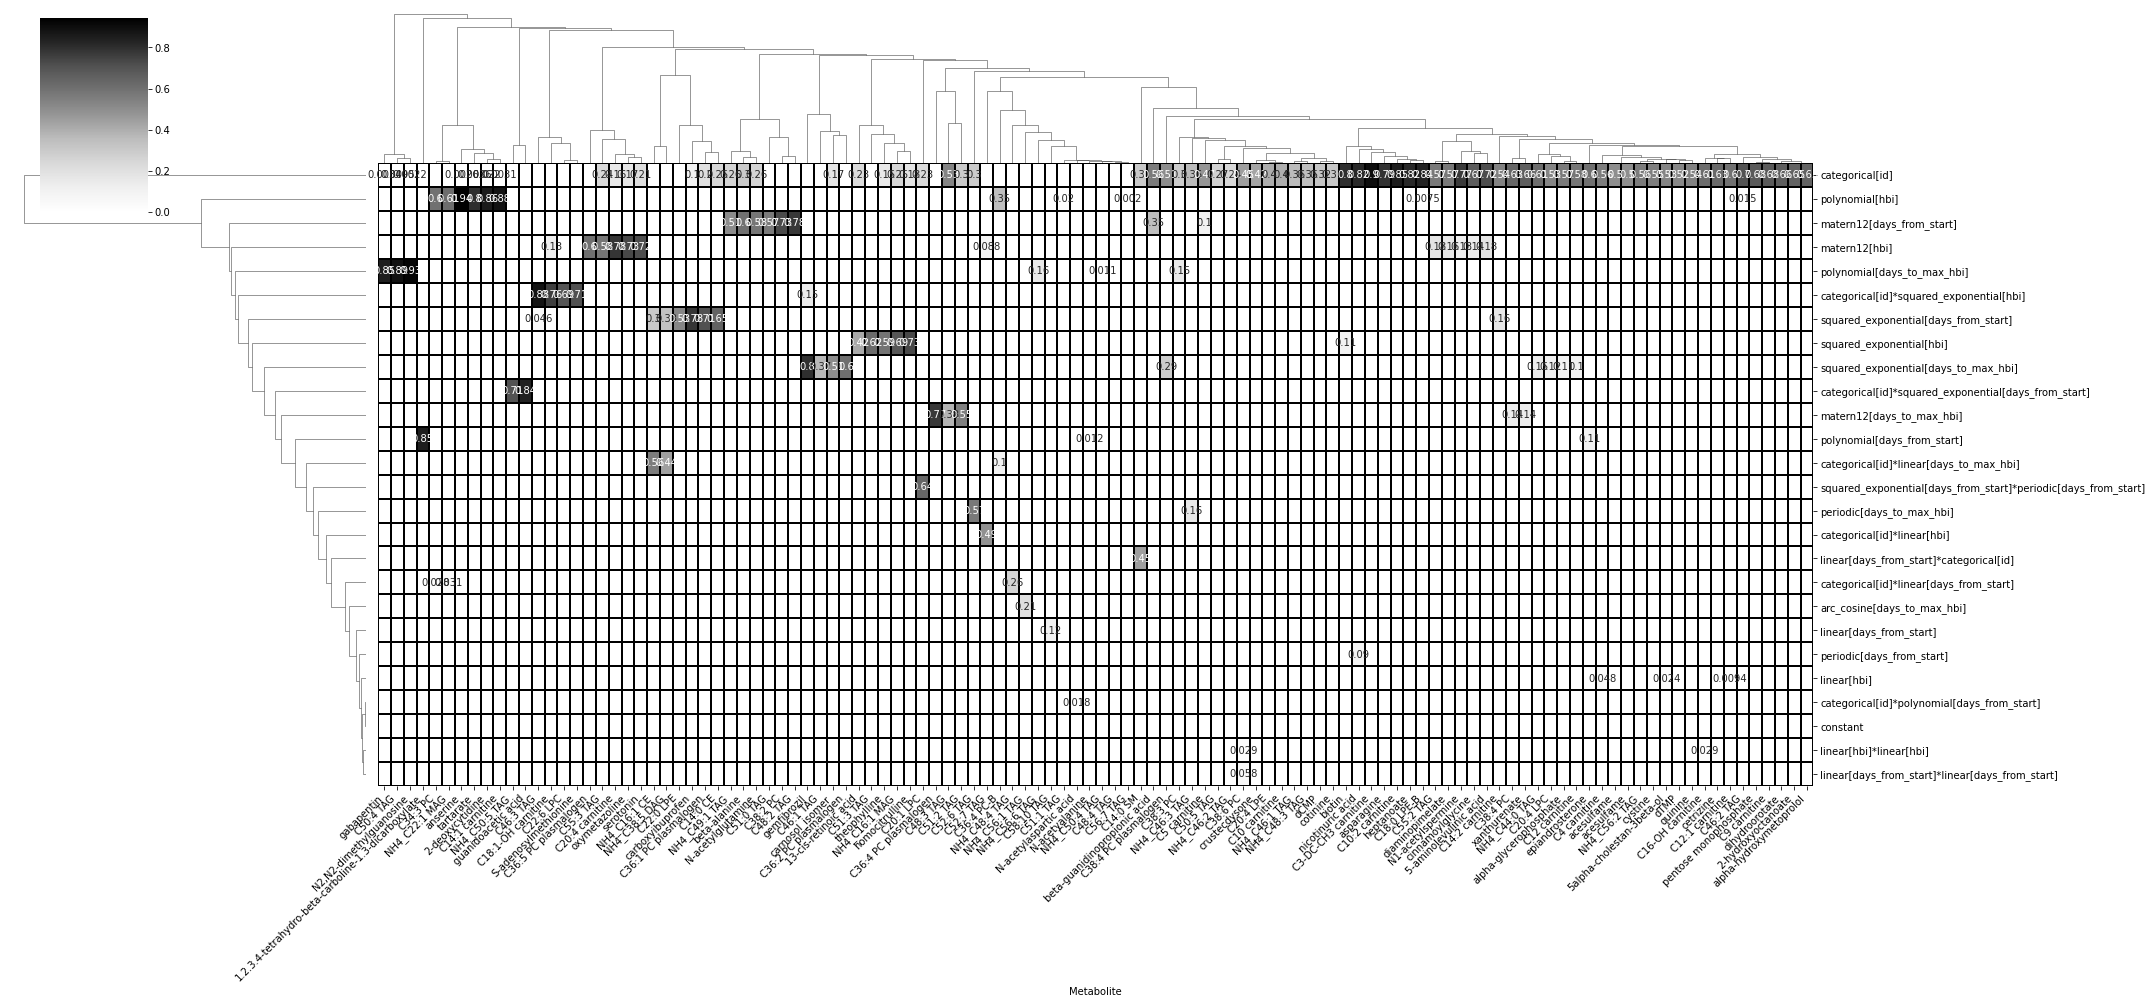

In [9]:
var_explained = [1-(x['var_exp'][-1]/sum(x['var_exp'])) if sum(x['var_exp'])>0 else 0 for x in binomial_models]
var_components = [x['var_exp'] for x in binomial_models]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]

# Barplot of variance explained
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(
    x=[var_explained[x] for x in np.argsort(var_explained)[::-1]], 
    y=missing_mbx_list[:n_met][np.argsort(var_explained)[::-1]],
    color='black',
)

kernels = [x['best_model'].split('+') for x in binomial_models]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x])
                         for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]

distinct_kernel_names = distinct_kernels.copy()
for i, c in enumerate(['[id]', '[hbi]', '[days_from_start]', '[days_to_max_hbi]']):
    distinct_kernel_names = [x.replace('['+str(i)+']', c) for x in distinct_kernel_names]

clm = sns.clustermap(pd.DataFrame(kernel_array, 
                            index=missing_mbx_list[:n_met], #sim_df[3].columns[3:], #np.arange(Y.shape[1]),
                            columns=distinct_kernel_names).transpose(),
              figsize=(30, 15),
              cmap='Greys',
              linecolor='black',
              linewidths=1.5,
              annot=True)
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
for t in clm.ax_heatmap.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

Best kernel: polynomial[2]+categorical[0]*linear[2]


/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


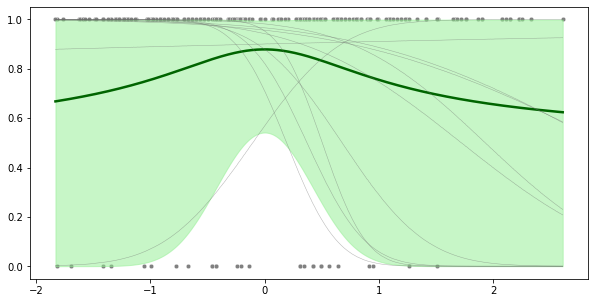

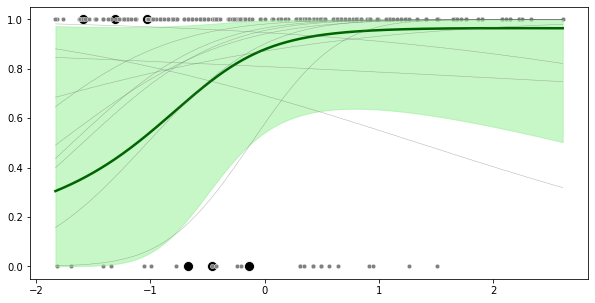

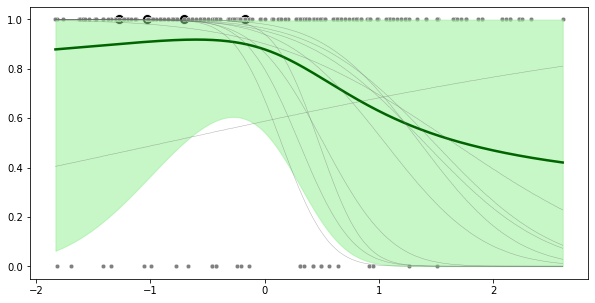

In [11]:
# carboxyibuprofen, cetrizine
mbx_idx = np.argwhere([x == '1.2.3.4-tetrahydro-beta-carboline-1.3-dicarboxylate' for x in missing_mbx_list]).tolist()[0][0]
cur_metabolite = missing_mbx_list[mbx_idx] 
cur_kernel = binomial_models[mbx_idx]['best_model'] 

print(f'Best kernel: {cur_kernel}')

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=2, 
    unit_idx=0,
    unit_label=None
);

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=2, 
    unit_idx=0,
    unit_label=1
);


gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=2, 
    unit_idx=0,
    unit_label=2
);

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


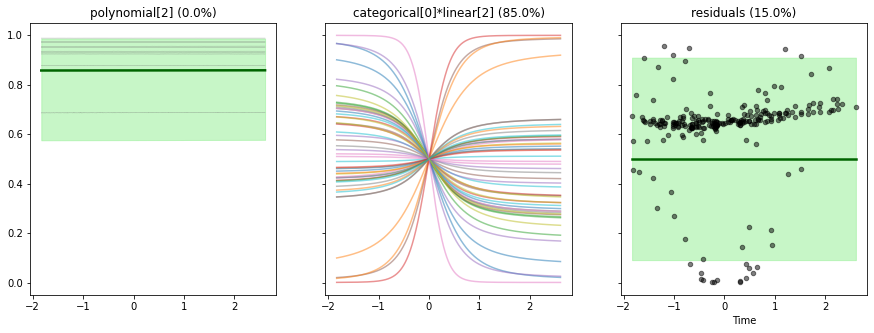

In [12]:
pred_kernel_parts2(
    m=binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    k_names=cur_kernel,
    time_idx=2,
    unit_idx=0,
    lik='bernoulli'
);

Best kernel: categorical[0]+polynomial[3]


/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


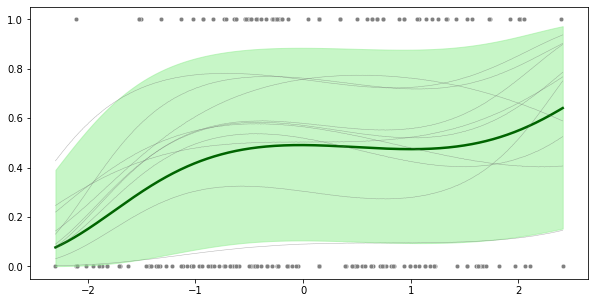

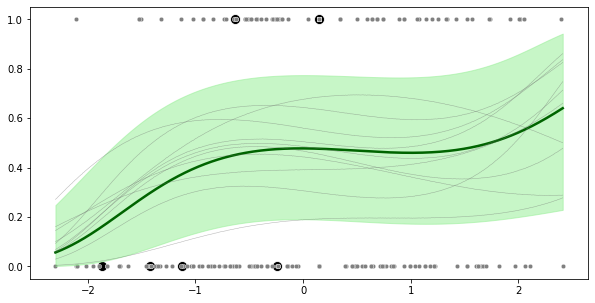

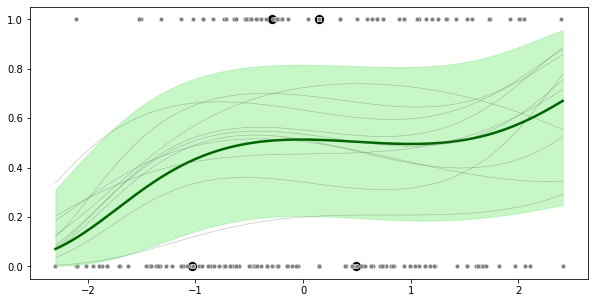

In [13]:
# carboxyibuprofen, cetrizine
mbx_idx = np.argwhere([x == 'C38:3 PC' for x in missing_mbx_list]).tolist()[0][0]
cur_metabolite = missing_mbx_list[mbx_idx] 
cur_kernel = binomial_models[mbx_idx]['best_model'] 

print(f'Best kernel: {cur_kernel}')

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=None
);

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=1
);


gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=3, 
    unit_idx=0,
    unit_label=2
);

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


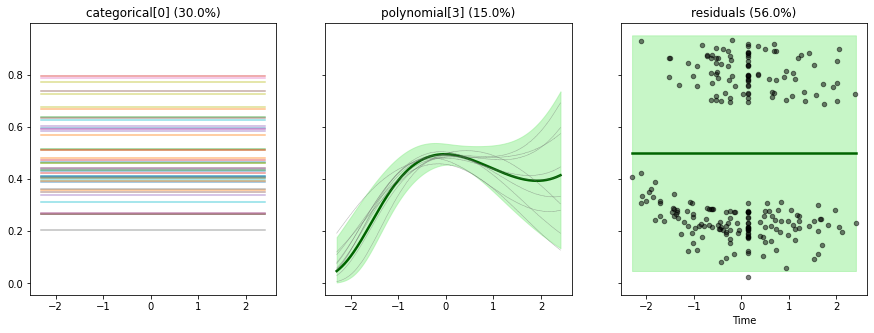

In [14]:
pred_kernel_parts2(
    m=binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    k_names=cur_kernel,
    time_idx=3,
    unit_idx=0,
    lik='bernoulli'
);

Best kernel: categorical[0]*squared_exponential[1]+squared_exponential[2]


/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


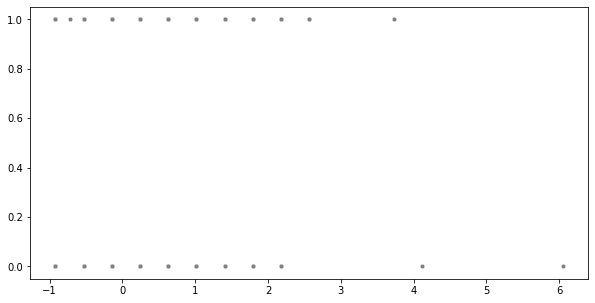

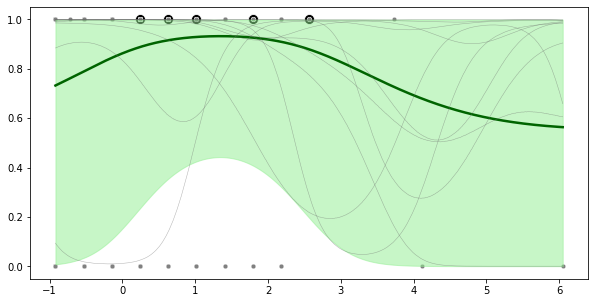

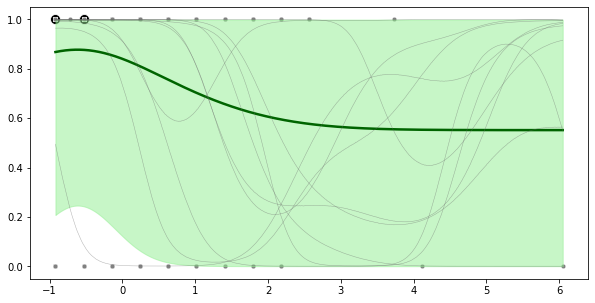

In [15]:
# Person specific metabolite example
mbx_idx = np.argwhere([x == 'C46:3 TAG' for x in missing_mbx_list]).tolist()[0][0]
cur_metabolite = missing_mbx_list[mbx_idx] 
cur_kernel = binomial_models[mbx_idx]['best_model'] 

print(f'Best kernel: {cur_kernel}')

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=1, 
    unit_idx=0,
    unit_label=None
);

gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=1, 
    unit_idx=0,
    unit_label=1
);


gp_predict_fun(
    binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    # binomial_dict[cur_metabolite][cur_kernel]['model'], 
    x_idx=1, 
    unit_idx=0,
    unit_label=2
);

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


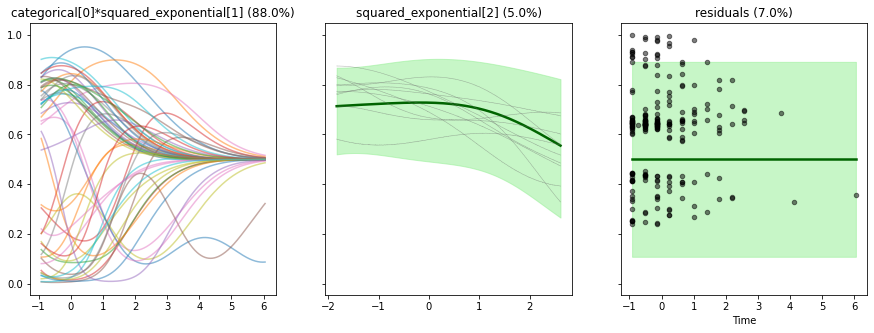

In [16]:
pred_kernel_parts2(
    m=binomial_models[mbx_idx]['models'][cur_kernel]['model'],
    k_names=cur_kernel,
    time_idx=1,
    unit_idx=0,
    lik='bernoulli'
);

Now lets see if we can fit one of these final models with an MCMC method for a full posterior.

## iHMP Stage Two Model Search

In [3]:
# Specify kernels to search over for continuous features
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

# Number of metabolites
n_met = len(mbx_list) #9 #30

standardized_df = (np.log(df) - np.log(df).mean())/np.log(df).std()

with tqdm_joblib(tqdm(desc="Kernel search", total=n_met)) as progress_bar:
    gaussian_models = Parallel(n_jobs=-2, verbose=1)(delayed(full_kernel_search)(
            X=df[['id', 'hbi', 'days_from_start', 'days_to_max_hbi']].to_numpy().reshape(-1, 4),
            Y=standardized_df[[m]].to_numpy().reshape(-1, 1),
            kern_list=kernel_list,
            cat_vars=[0],
            max_depth=5,
            early_stopping=True,
            prune=True,
            keep_all=False,
            lik='gaussian',
            random_seed=9102)
        for m in mbx_list[:n_met])
    
# Transform list output into dictionary to pull of metabolites of interest
# gaussian_dict = {k: v[0] for k,v in zip(mbx_list[:n_met], gaussian_models)}

Kernel search: 100%|████████████████████████| 587/587 [3:02:34<00:00, 18.66s/it]


In [4]:
# Save output
f = open("ihmp_gaussian_models.pkl","wb")
pickle.dump(gaussian_models, f)
f.close()

In [18]:
# Load output if needed
gaussian_models = pickle.load(open("ihmp_gaussian_models.pkl", "rb" ))

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


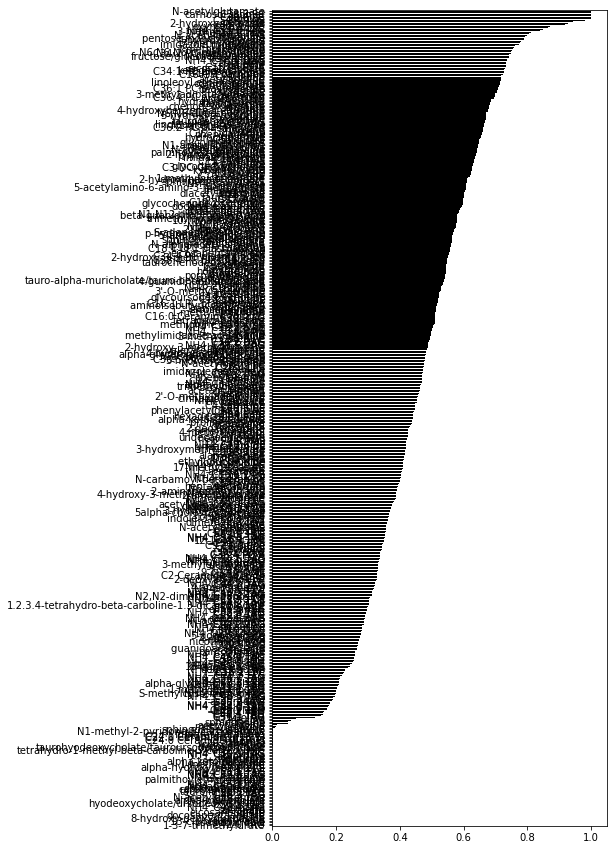

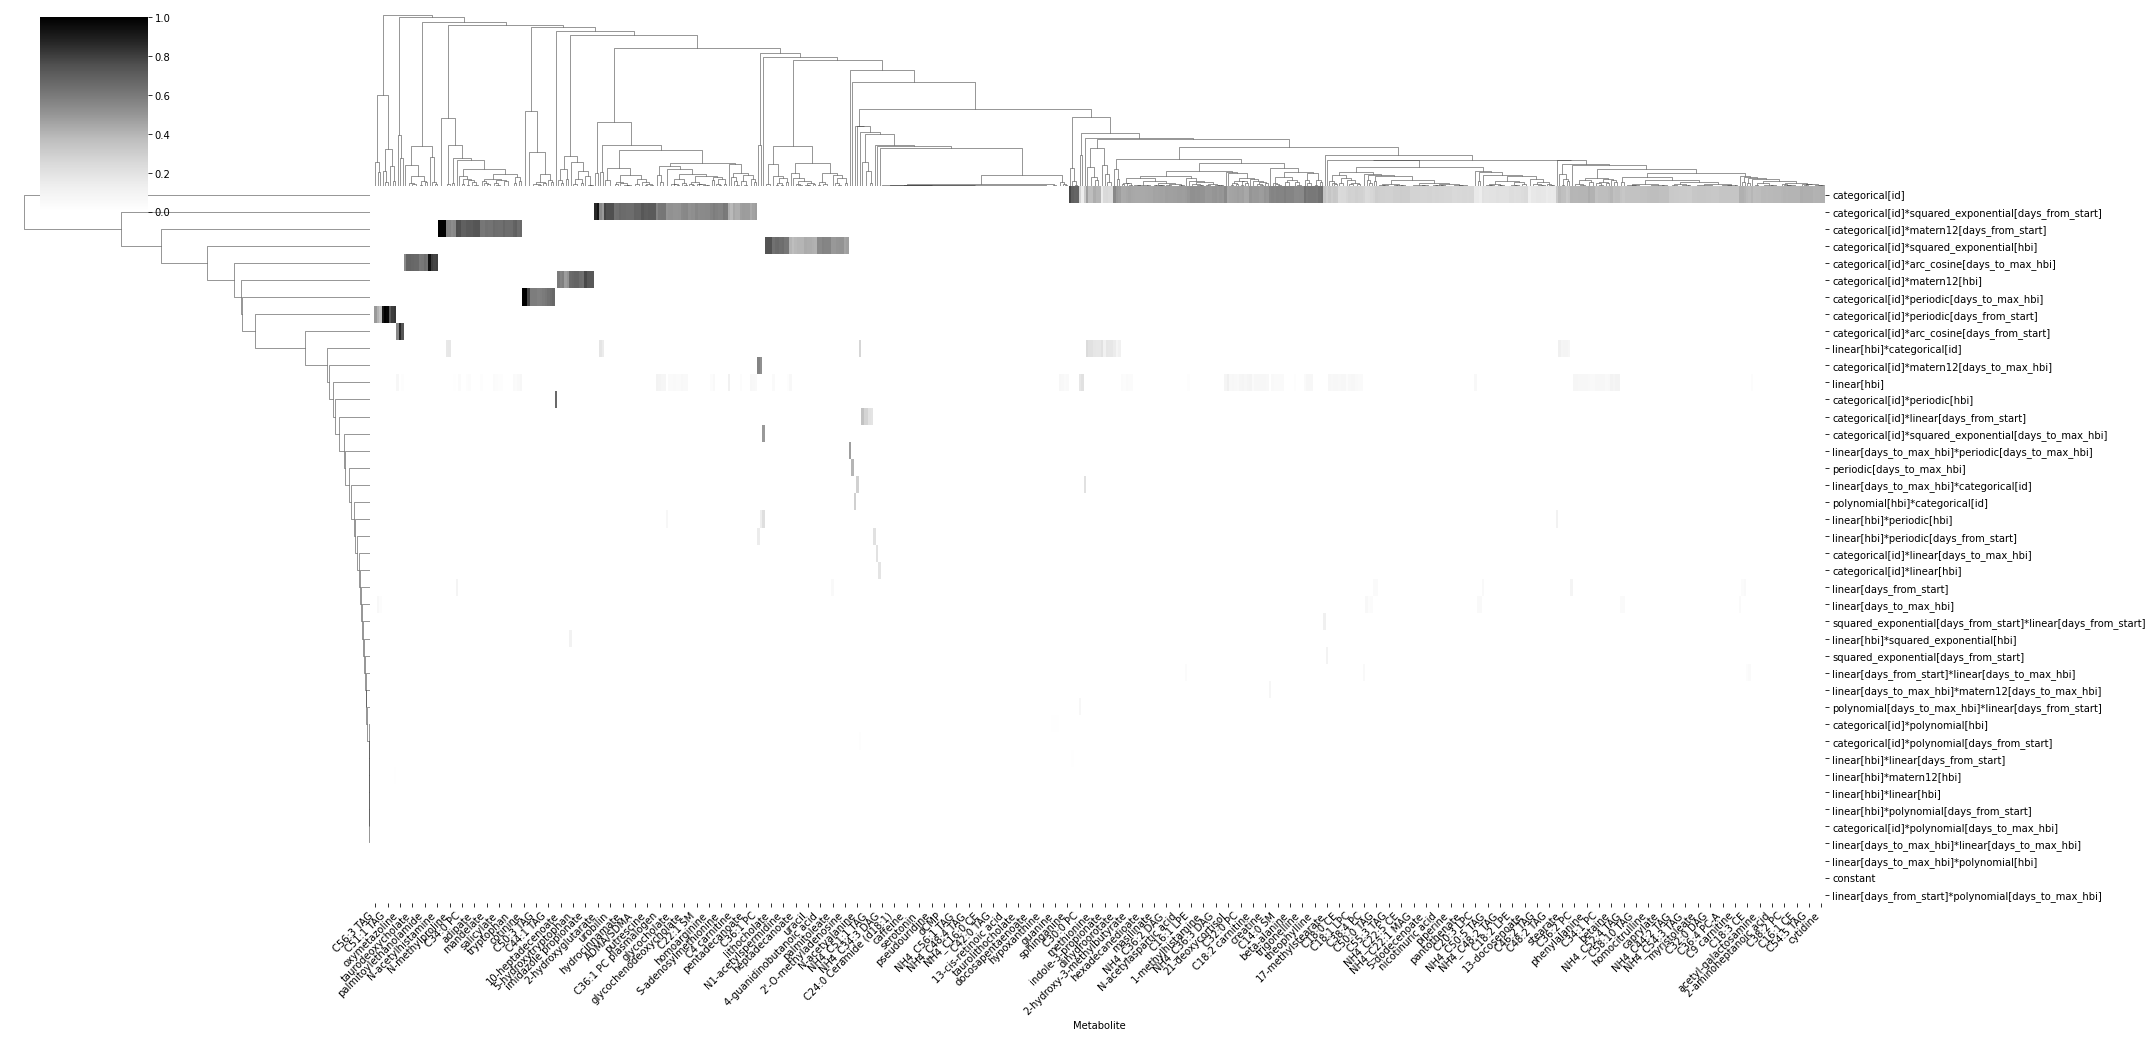

In [24]:
var_explained = [1-(x['var_exp'][-1]/sum(x['var_exp'])) if sum(x['var_exp'])>0 else 0 for x in gaussian_models]
var_components = [x['var_exp'] for x in gaussian_models]
var_percent = [[y/sum(x) if sum(x) > 0 else 0 for y in x][:-1] for x in var_components]

# import seaborn as sns
# sns.barplot(y=mbx_list[:n_met], 
#             x=var_explained)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total variance explained
sns.barplot(
    x=[var_explained[x] for x in np.argsort(var_explained)[::-1]], 
    # y=mbx_list[:n_met].values[np.argsort(var_explained)[::-1]],
    y=mbx_list.values[np.argsort(var_explained)[::-1]],
    color='black'
)

kernels = [x['best_model'].split('+') for x in gaussian_models]
distinct_kernels = np.unique([item for sublist in kernels for item in sublist])
kernel_array = np.zeros(shape=(len(kernels), len(distinct_kernels)))
kernel_idxs = np.vstack([sum([np.where(distinct_kernels==y, 1, 0) for y in x]) for x in kernels])

# Just fill in indicators now
kernel_array[kernel_idxs == 1] = [x for y in var_percent for x in y]

distinct_kernel_names = distinct_kernels.copy()
for i, c in enumerate(['[id]', '[hbi]', '[days_from_start]', '[days_to_max_hbi]']):
    distinct_kernel_names = [x.replace('['+str(i)+']', c) for x in distinct_kernel_names]

clm = sns.clustermap(pd.DataFrame(kernel_array, 
                            index=mbx_list, #mbx_list[:n_met], #sim_df[3].columns[3:], #np.arange(Y.shape[1]),
                            columns=distinct_kernel_names).transpose(),
              figsize=(30, 15),
              cmap='Greys',
              #linecolor='black',
              #linewidths=1.5,
              #annot=True
                    )
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right');
# for t in clm.ax_heatmap.texts:
#     if float(t.get_text())>0:
#         t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
#     else:
#         t.set_text("") # if not it sets an empty text

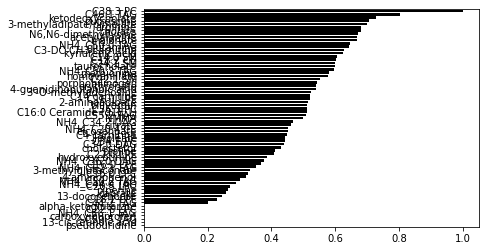

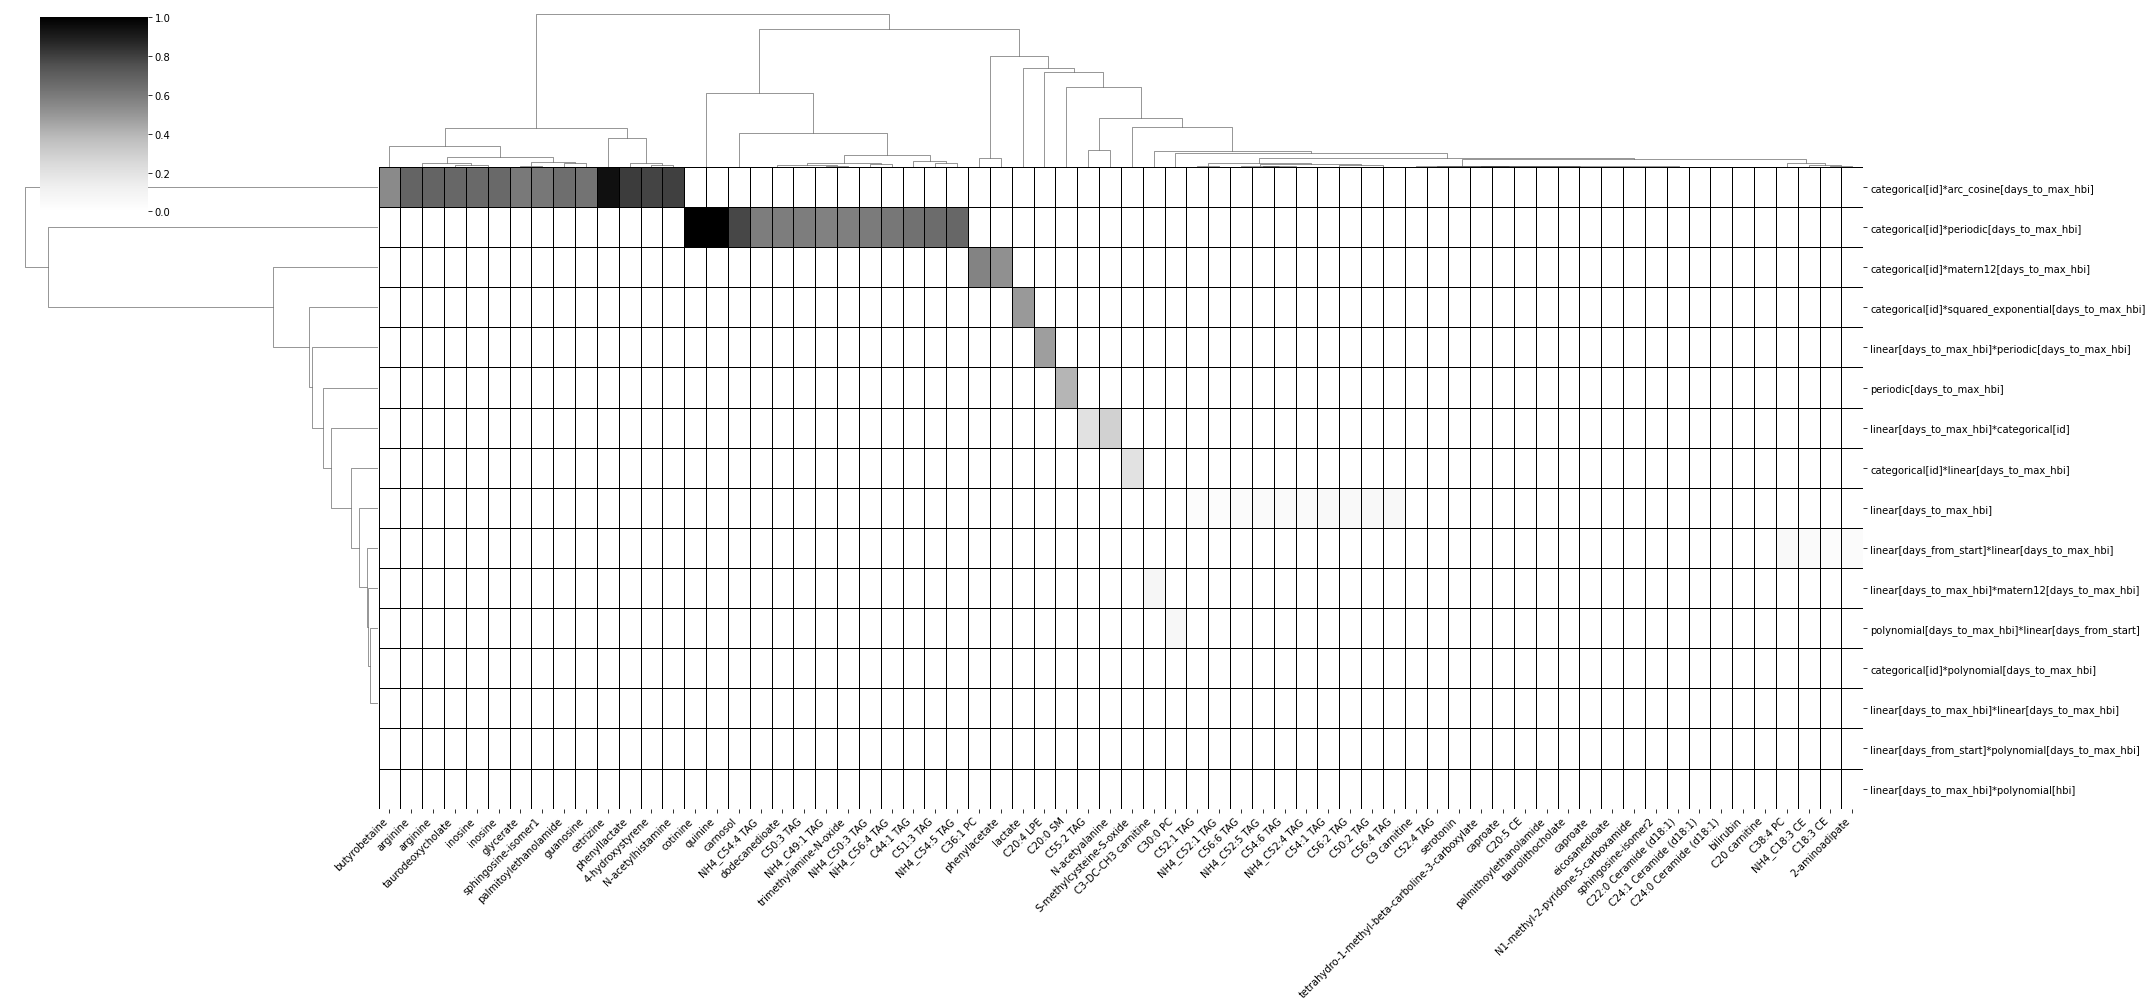

In [143]:
# Can we pull off all metabolites that have some indication of days_to_max_hbi as a useful feature?
dtmb_idx = np.where(np.sum(kernel_idxs[:,['days_to_max_hbi' in x for x in distinct_kernel_names]], axis=1) > 0)[0]
sns.barplot(
    x=[[var_explained[x] for x in np.argsort(var_explained)[::-1]][x] for x in dtmb_idx], 
    y=[mbx_list.values[np.argsort(var_explained)[::-1]][x] for x in dtmb_idx],
    color='black'
)

clm = sns.clustermap(pd.DataFrame(kernel_array[:,['days_to_max_hbi' in x for x in distinct_kernel_names]][dtmb_idx,:], 
                            index=[mbx_list.values[x] for x in dtmb_idx],
                            columns=[x for x in distinct_kernel_names if 'days_to_max_hbi' in x]).transpose(),
              figsize=(30, 15),
              cmap='Greys',
              linecolor='black',
              linewidths=0.5,
                    )
plt.setp(clm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right');

/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


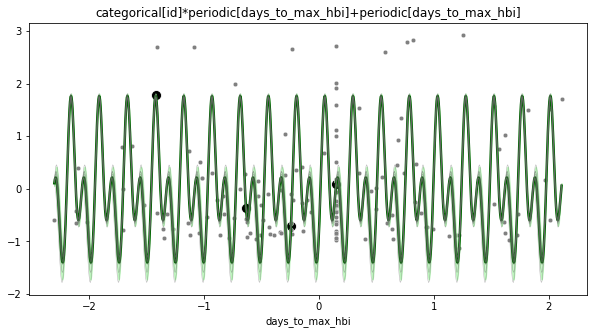

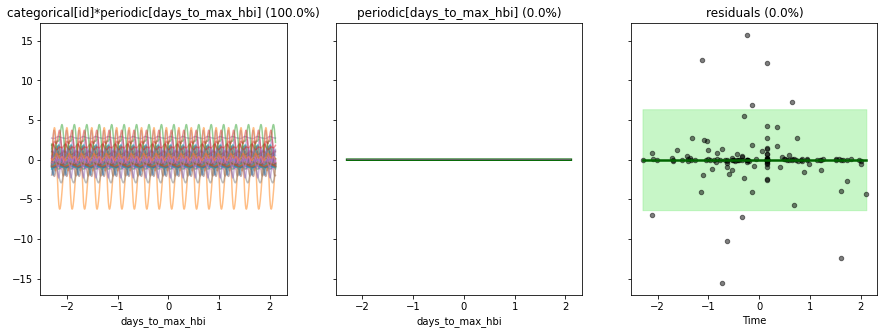

In [203]:
mbx_idx = np.argwhere([x == 'cotinine' for x in mbx_list]).tolist()[0][0]
cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
# observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

# Plot posterior distribution
p = gp_predict_fun(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1], 
    x_idx=3, 
    unit_idx=0,
    unit_label=1,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
).set_title(replace_kernel_variables(cur_kernel, ['id', 'hbi', 'days_from_start', 'days_to_max_hbi']))
# Print resulting decomposition
pred_kernel_parts(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1],
    cur_kernel,
    time_idx=3,
    unit_idx=0,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
);

Best kernel: categorical[0]*periodic[3]


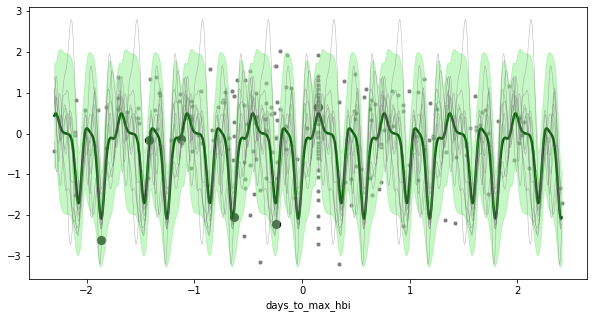

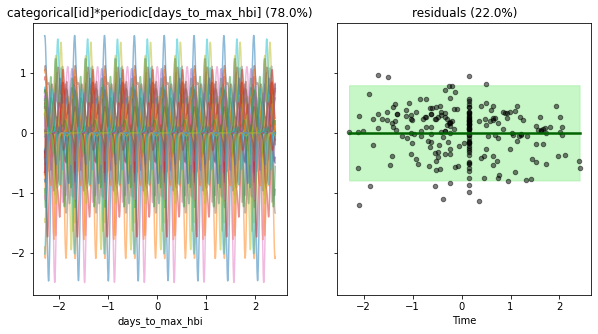

In [204]:
# butyrate
# heptanoate
mbx_idx = np.argwhere([x == 'carnosol' for x in mbx_list]).tolist()[0][0]
cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
# observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

print(f"Best kernel: {cur_kernel}")

# Plot posterior distribution
p = gp_predict_fun(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1], 
    x_idx=3, 
    unit_idx=0,
    unit_label=1,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
)
# Print resulting decomposition
pred_kernel_parts(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1],
    cur_kernel,
    time_idx=3,
    unit_idx=0,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
);

Best kernel: categorical[0]*squared_exponential[3]+linear[1]*periodic[1]


/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


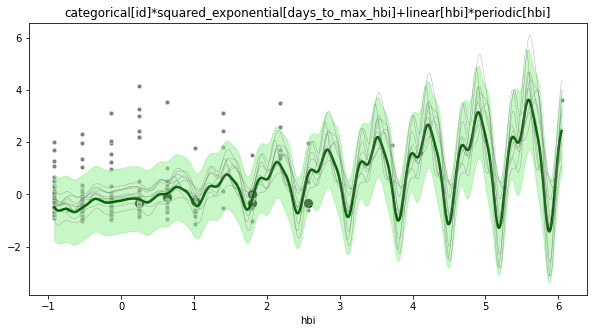

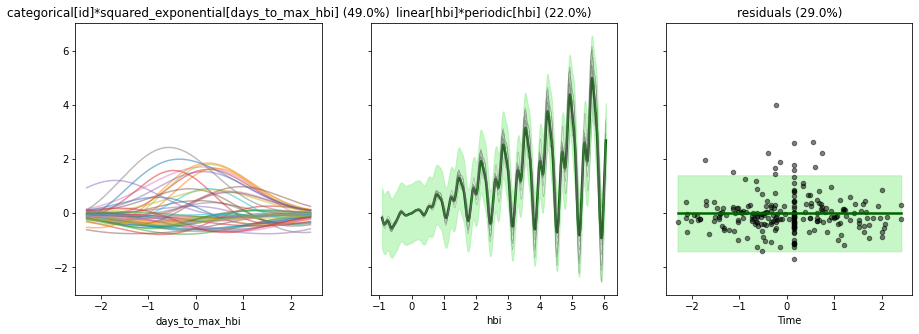

In [201]:
mbx_idx = np.argwhere([x == 'lactate' for x in mbx_list]).tolist()[0][0]
cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
# observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

print(f"Best kernel: {cur_kernel}")

# Plot posterior distribution
p = gp_predict_fun(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1], 
    x_idx=1, 
    unit_idx=0,
    unit_label=1,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
).set_title(replace_kernel_variables(cur_kernel, ['id', 'hbi', 'days_from_start', 'days_to_max_hbi']))
# Print resulting decomposition
pred_kernel_parts(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1],
    cur_kernel,
    time_idx=3,
    unit_idx=0,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
);

Best kernel: categorical[0]*arc_cosine[3]


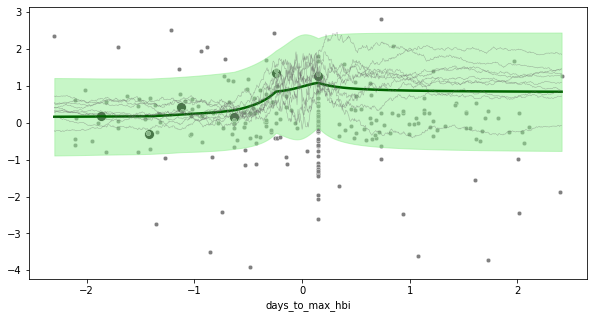

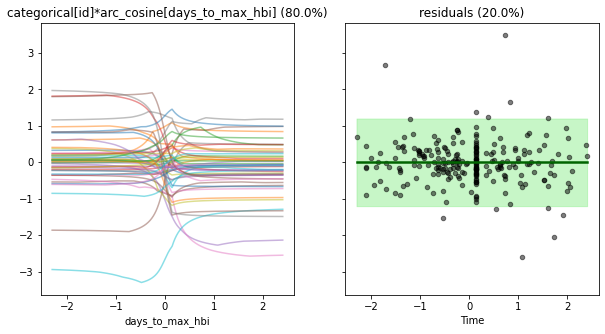

In [205]:
# butyrate
# heptanoate
mbx_idx = np.argwhere([x == 'N-acetylhistamine' for x in mbx_list]).tolist()[0][0]
cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
# observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

print(f"Best kernel: {cur_kernel}")

# Plot posterior distribution
p = gp_predict_fun(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1], 
    x_idx=3, 
    unit_idx=0,
    unit_label=1,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
)
# Print resulting decomposition
pred_kernel_parts(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1],
    cur_kernel,
    time_idx=3,
    unit_idx=0,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
);

Best kernel: categorical[0]+polynomial[3]*linear[2]+linear[1]


/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


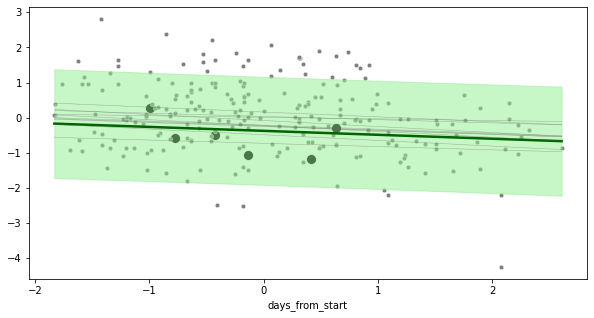

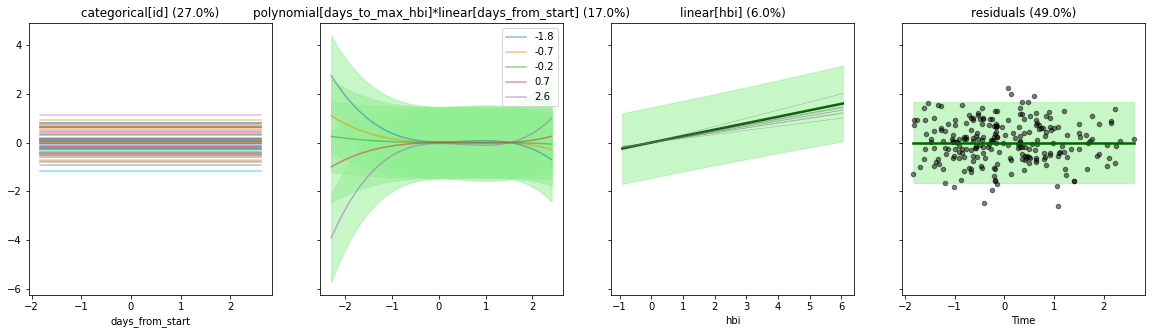

In [207]:
# butyrate
# heptanoate
mbx_idx = np.argwhere([x == 'C30:0 PC' for x in mbx_list]).tolist()[0][0]
cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
# observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

print(f"Best kernel: {cur_kernel}")

# Plot posterior distribution
p = gp_predict_fun(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1], 
    x_idx=2, 
    unit_idx=0,
    unit_label=5,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
)
# Print resulting decomposition
pred_kernel_parts(
    gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    # gaussian_dict[cur_metabolite][cur_kernel][1],
    cur_kernel,
    time_idx=2,
    unit_idx=0,
    col_names=['id', 'hbi', 'days_from_start', 'days_to_max_hbi']
);

Best kernel: categorical[0]*matern12[2] for metabolite N-acetylglutamate
Best kernel: categorical[0]*periodic[2] for metabolite carnosol_isomer
Best kernel: categorical[0]*matern12[2] for metabolite C38:3 PC


/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge_x86/envs/gp_x86/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Best kernel: categorical[0]*periodic[3] for metabolite quinine
Best kernel: categorical[0]*matern12[2] for metabolite C38:6 PC


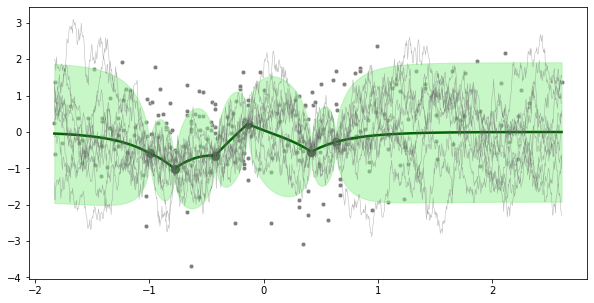

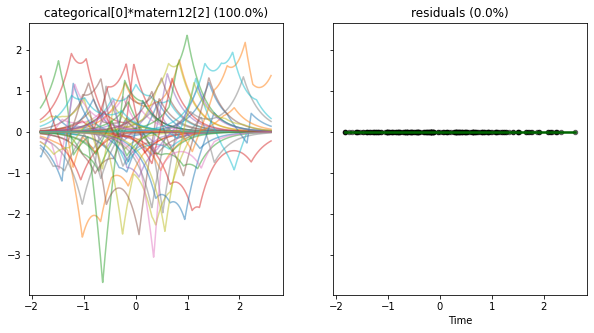

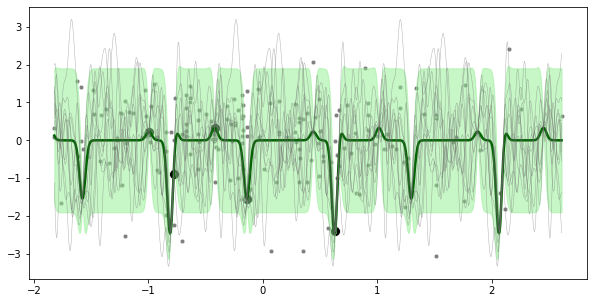

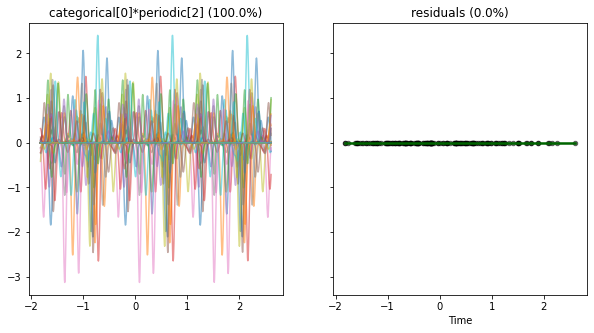

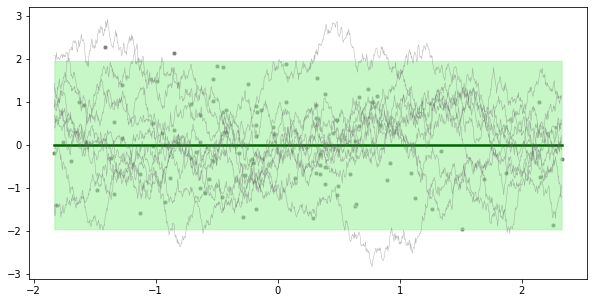

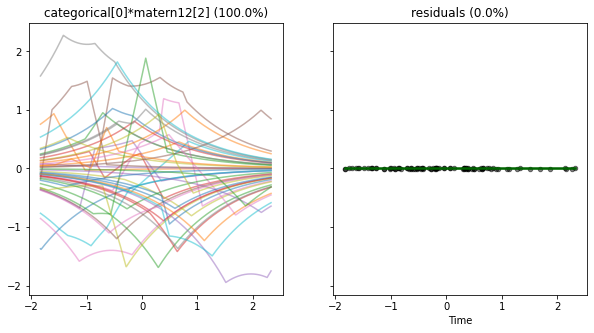

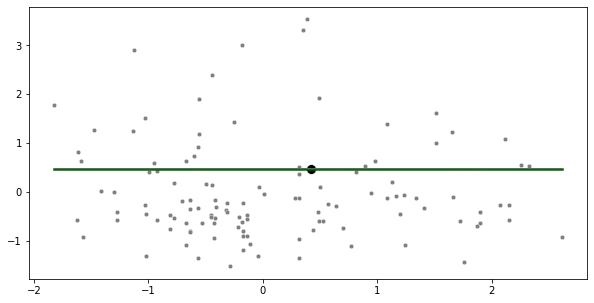

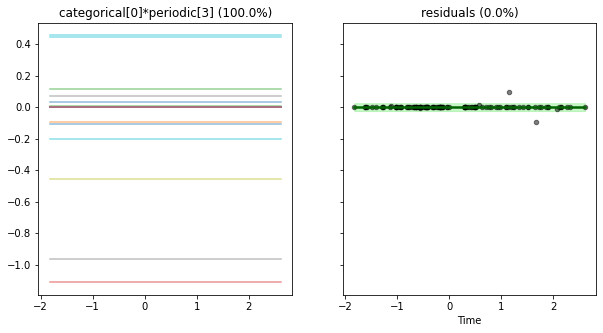

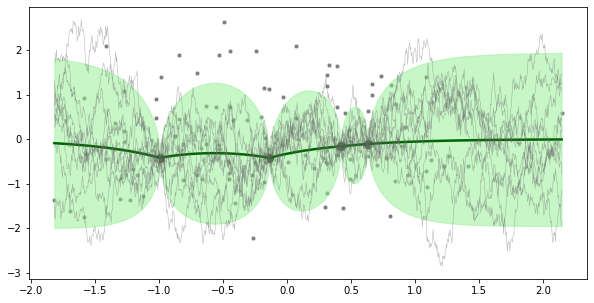

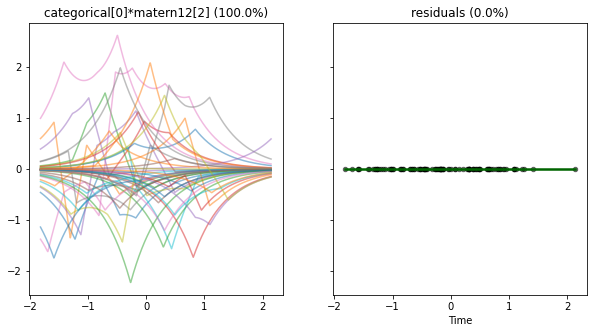

In [138]:
# Can we just look at the top five metabolites with the greatest explained variance?
top_five_idx = np.argsort(var_explained)[::-1][:5]

for m in top_five_idx:
    mbx_idx = m
    cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
    cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
    # observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

    print(f"Best kernel: {cur_kernel} for metabolite {cur_metabolite}")

    # Plot posterior distribution
    p = gp_predict_fun(
        gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
        # gaussian_dict[cur_metabolite][cur_kernel][1], 
        x_idx=2, 
        unit_idx=0,
        unit_label=5
    )
    # Print resulting decomposition
    pred_kernel_parts2(
        gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
        # gaussian_dict[cur_metabolite][cur_kernel][1],
        cur_kernel,
        time_idx=2,
        unit_idx=0
    );

## HMC Sampling

In [14]:
c_samples, samples, traces = hmc_sampling(
    model = gaussian_dict[cur_metabolite][cur_kernel][1]
)

KeyboardInterrupt: 

In [86]:
foo = gpflow.models.GPMC(
    data = (df[['id', 'hbi', 'days_from_start']].to_numpy().reshape(-1, 3),
            df[[m]].isna().astype(int).to_numpy().reshape(-1, 1)),
    kernel = Categorical(active_dims=[0]),
    likelihood = gpflow.likelihoods.Gaussian())

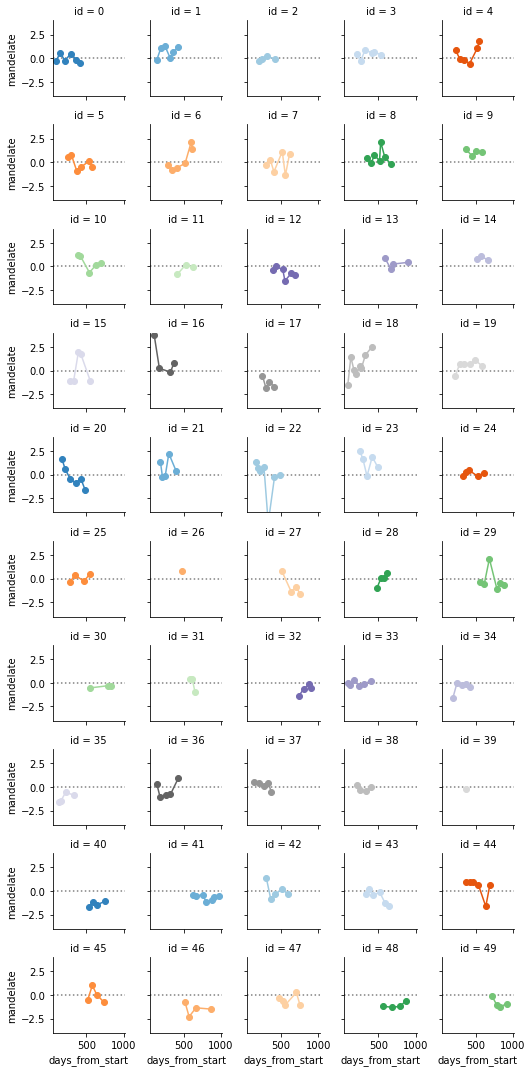

In [78]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df[['id', 'days_from_start', 'mandelate']].sort_values(by=['id', 'days_from_start']), 
                     col="id", hue="id", palette="tab20c",
                     col_wrap=5, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "days_from_start", "mandelate", marker="o")

# Adjust the tick positions and labels
grid.set(ylim=(-4, 4))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

Flip the X and Y search to find relationships with HBI

In [6]:
%%time
hbi_model = full_kernel_search(
    X=df.drop(['hbi'], axis=1).fillna(0).to_numpy().reshape(-1, 553),
    Y=df[['hbi']].to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.ArcCosine()],
    cat_vars=[],
    max_depth=3,
    early_stopping=True,
    prune=True,
    keep_all=False,
    lik='gaussian',
    verbose=False
)

Optimization not successful, skipping.
arc_cosine[123]*arc_cosine[498]
CPU times: user 2h 58min 57s, sys: 16min 9s, total: 3h 15min 6s
Wall time: 2h 3min 13s


In [10]:
hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1]

<gpflow.models.gpr.GPR object at 0x7fb6587715e0>
╒════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                                   │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                    │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [2.52479895]           │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 25.405110621075966     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 25.18753071214904      │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.4648888609643005e-12 │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].variance         │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0                    │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 8.629136956169125      │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.00019943660766734504 │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.likelihood.variance                │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.5772653636730716     │
╘════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════════╛

Metabolite 123
Metabolite 498


<AxesSubplot:>

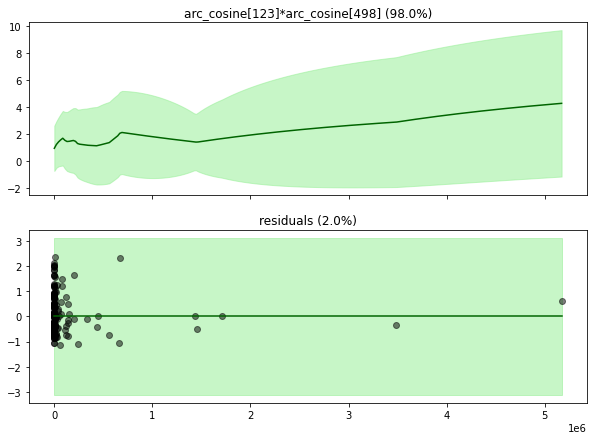

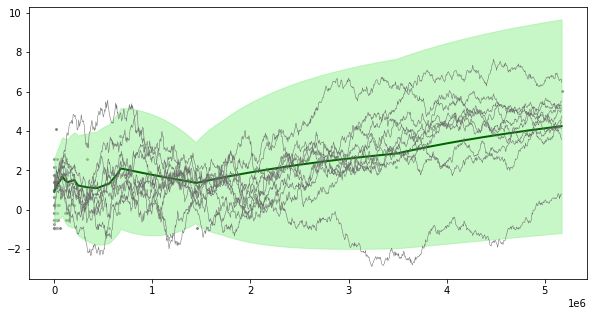

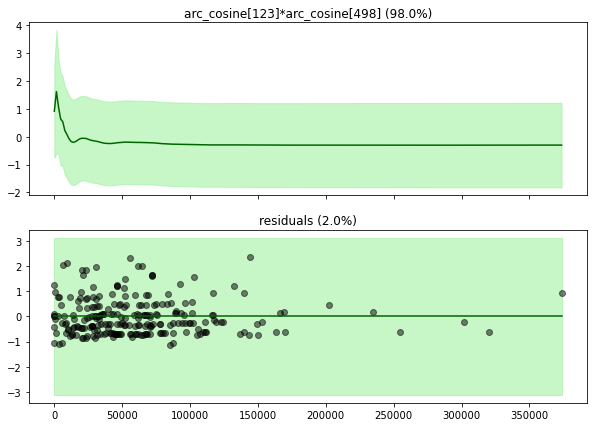

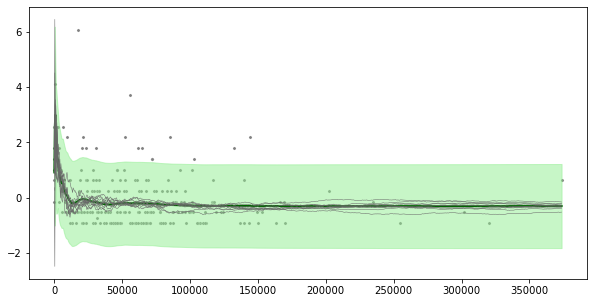

In [14]:
# Print resulting decomposition
print('Metabolite 123')
pred_kernel_parts(hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1],
                  'arc_cosine[123]*arc_cosine[498]',
                  x_idx=123)
gp_predict_fun(
    hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1], 
    x_idx=123, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)

print('Metabolite 498')
pred_kernel_parts(hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1],
                  'arc_cosine[123]*arc_cosine[498]',
                  x_idx=498)

gp_predict_fun(
    hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1], 
    x_idx=498, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)


In [18]:
# Which metabolites are these?
df.drop(['id', 'hbi'], axis=1).columns[[123, 498]]

Index(['C38:3 PC', 'cortisol'], dtype='object')

In [4]:
int_model = gpflow.models.GPR(
    data=(df[['C38:3 PC', 'cortisol']].fillna(0).to_numpy().reshape(-1, 2),
          df.hbi.to_numpy().reshape(-1, 1)),
    kernel=gpflow.kernels.ArcCosine(active_dims=[0])*gpflow.kernels.ArcCosine(active_dims=[1]),
    mean_function=gpflow.mean_functions.Constant())

opt_results = gpflow.optimizers.Scipy().minimize(
                int_model.training_loss,
                int_model.trainable_variables)

In [5]:
int_model

<gpflow.models.gpr.GPR object at 0x7fcb64381370>
╒════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                                   │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                    │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [8.89900516]           │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 12.997128050057611     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 21.246525691023113     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.768662316411443e-12  │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].variance         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 12.997128050080763     │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].bias_variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.864056279920286      │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].weight_variances │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.00013386546254106477 │
├────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.likelihood.variance                │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 3.853896225206588      │
╘════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════════╛

<AxesSubplot:>

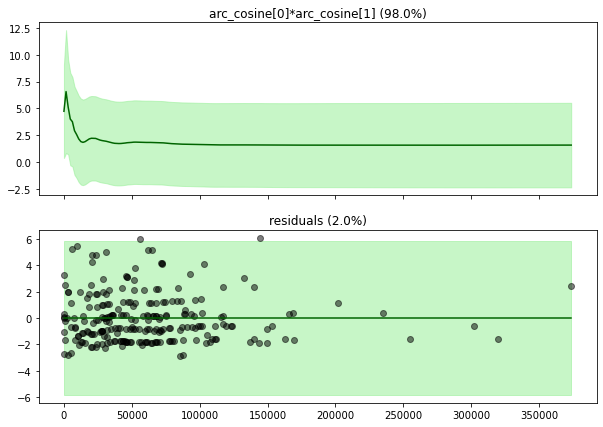

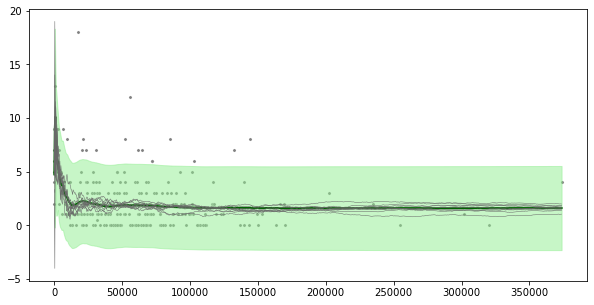

In [6]:
pred_kernel_parts(int_model,
#                   'squared_exponential[0]*squared_exponential[1]',
                  'arc_cosine[0]*arc_cosine[1]',
                  x_idx=1)

gp_predict_fun(
    int_model, 
    x_idx=1, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)

In [69]:
'*' in 'arc_cosine[0]*arc_cosine[1]'

True

In [63]:
x1 = np.linspace(0, df['C38:3 PC'].max(), num=100).round(0)
x2 = np.linspace(0, df['cortisol'].max(), num=100).round(0)
x_new = np.array(
    np.meshgrid(
        x1, x2
    )
).T.reshape(-1, 2)

mean_y, var_y = int_model.predict_y(
    Xnew = x_new
)

In [101]:
var_y

<tf.Tensor: shape=(10000, 1), dtype=float64, numpy=
array([[4.89433849],
       [5.12543689],
       [4.39932493],
       ...,
       [7.77666255],
       [7.77725733],
       [7.77784009]])>

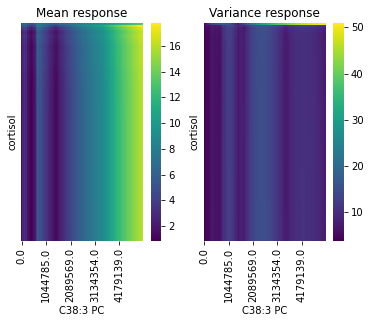

In [109]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

sns.heatmap(pd.DataFrame({'mean':mean_y.numpy().flatten(), 
              'cortisol': x_new[:,1].flatten(), 
              'C38:3 PC': x_new[:,0].flatten()}).pivot('cortisol', 'C38:3 PC', 'mean'),
           xticklabels=20,
           yticklabels=20,
           cmap='viridis',
           ax=ax1)
ax1.set_title('Mean response')
sns.heatmap(pd.DataFrame({'var':var_y.numpy().flatten(), 
              'cortisol': x_new[:,1].flatten(), 
              'C38:3 PC': x_new[:,0].flatten()}).pivot('cortisol', 'C38:3 PC', 'var'),
           xticklabels=20,
           yticklabels=False,
           cmap='viridis',
           ax=ax2)
ax2.set_title('Variance response')

plt.show()

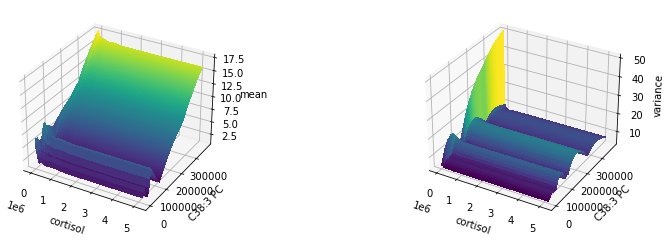

In [126]:
from mpl_toolkits.mplot3d import Axes3D
x1_, x2_ = np.meshgrid(x1, x2)


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

# Mean response
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
ax.plot_surface(x1_, x2_, mean_y.numpy().reshape(x1_.shape), 
                rstride=1, cstride=1, cmap='viridis',
                linewidth=0, antialiased=False)
ax.set_ylabel('C38:3 PC')
ax.set_xlabel('cortisol')
ax.set_zlabel('mean')

# Variance response
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(x1_, x2_, var_y.numpy().reshape(x1_.shape), 
                rstride=1, cstride=1, cmap='viridis',
                linewidth=0, antialiased=False)
ax.set_ylabel('C38:3 PC')
ax.set_xlabel('cortisol')
ax.set_zlabel('variance')
plt.show()

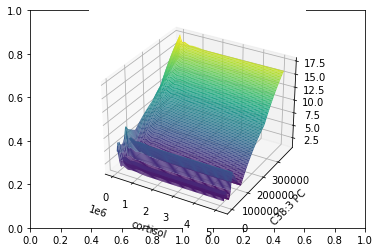

In [111]:
from mpl_toolkits.mplot3d import Axes3D

x1_, x2_ = np.meshgrid(x1, x2)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1 = plt.axes(projection='3d')
ax1.plot_surface(x1_, x2_, 
                mean_y.numpy().reshape(x1_.shape), 
                rstride=1, 
                cstride=1,
                cmap='viridis', 
                edgecolor='none')
ax1.set_ylabel('C38:3 PC')
ax1.set_xlabel('cortisol');

In [70]:
%%time
hbi_model2 = full_kernel_search(
    X=df.drop(['hbi'], axis=1).fillna(0).to_numpy().reshape(-1, 553),
    Y=df[['hbi']].to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.ArcCosine()],
    cat_vars=[0],
    max_depth=3,
    early_stopping=True,
    prune=True,
    keep_all=False,
    lik='gaussian',
    verbose=False
)

Optimization not successful, skipping.
arc_cosine[124]*arc_cosine[499]
CPU times: user 2h 56min 17s, sys: 15min 32s, total: 3h 11min 50s
Wall time: 1h 59min 39s
